In [1]:
import pandas as pd
from docx import Document
from docx.shared import Inches
import numpy as np
from ast import literal_eval
import configparser
config = configparser.ConfigParser()
# from ipynb.fs.full.JUMP_l_modules import *
import matplotlib.pyplot as plt
import seaborn as sns
import os, path
from os.path import dirname
from pandas.plotting import table
import dataframe_image as dfi
from docx.shared import Pt
import pyteomics as pyteomics
from pyteomics import mzxml, auxiliary, pepxml

# sys.path.append("/home/spoudel1/bin/python/JUMP_localization_python/JUMP_localization")
from JUMP_l_modules import *

In [2]:
# params_file = sys.argv[1]
params_file = "jump_validator.params"
#params_file = "../parameterFile/map_comet_jump_fJUMP.params"
config.read(params_file)

['jump_validator.params']

In [3]:
'''
#this is the input excel file for the each peptide that are to be manually validated. Headers = Exp	scan	charge (Exp = experiment/fraction name, scan = scan number, charge = z)
peptideFile = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/Check_pho_peptides_Chao.xlsx

#this is the input ID.txt file. It can also be input from jump_l program ID.lscore file
jump_f_id = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/solubleTauPTMs/phosphorylation/ID.lscore

#this option says whether the output is from jump_l program or not. Type "yes" if JUMP_l was used for pho site localization else type "no"
jumpl = Yes

#path (folder) for .ms2 if .ms2 was used for searching
ms2_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng

#path (folder) for .mzXML 
mzXML_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng

#files used to extract ms2 information. options (ms2 or mzxml). If option is .ms2, the program will only use ms2_path and if option is .mzXML, the program will use mzXML_path

ms2_fileType = ms2

#list of symbols used in the modifications (dynamic modificaitons). This information you can get if from pep.xml files
dynMods = @:15.99492,*:79.966331,#:79.966331,%:79.966331

#list static modification in the parameter file. If you have n-term modification n:229.162932
staticMods = C:57.021464

#parameters for matching ions
#ion_types to analyze a.b.c,x,y,z
ion_types = b,y

#neutral losses to analyze H2O, NH3, H3PO4
ionLoss = NH3,H2O 

#tolerance for ms2 matching = fragment ion tolerance
tol=10
'''

'\n#this is the input excel file for the each peptide that are to be manually validated. Headers = Exp\tscan\tcharge (Exp = experiment/fraction name, scan = scan number, charge = z)\npeptideFile = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/Check_pho_peptides_Chao.xlsx\n\n#this is the input ID.txt file. It can also be input from jump_l program ID.lscore file\njump_f_id = /Users/spoudel1/Desktop/PTM_study/ChaoPeng/solubleTauPTMs/phosphorylation/ID.lscore\n\n#this option says whether the output is from jump_l program or not. Type "yes" if JUMP_l was used for pho site localization else type "no"\njumpl = Yes\n\n#path (folder) for .ms2 if .ms2 was used for searching\nms2_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng\n\n#path (folder) for .mzXML \nmzXML_path = /Users/spoudel1/Desktop/PTM_study/ChaoPeng\n\n#files used to extract ms2 information. options (ms2 or mzxml). If option is .ms2, the program will only use ms2_path and if option is .mzXML, the program will use mzXML_path\n\nms2_fil

In [4]:
peptideFile = config["caseEvaluation"]["peptideFile"]
jump_f_id = config["caseEvaluation"]["jump_f_id"]
jumpl = config["caseEvaluation"]["jumpl"]
ms2_path = config["caseEvaluation"]["ms2_path"]
mzXML_path = config["caseEvaluation"]["mzXML_path"]
ms2_fileType = config["caseEvaluation"]["ms2_fileType"]

ion_types = config["caseEvaluation"]["ion_types"]
ionLoss = config["caseEvaluation"]["ionLoss"]
tol = config["caseEvaluation"]["tol"]
out_fol = config["caseEvaluation"]["out_fol"]
#example pepxml file to parse the modification information
pepxml = config["caseEvaluation"]["pepxml"]

In [5]:
# peptideFile = "../PTM_study/ChaoPeng/solubleTauPTMs/phosphorylation/ID.lscore"
df_pho2 = pd.read_csv(jump_f_id,delimiter=";",skiprows=return_skiprows(jump_f_id,";", "Peptide"))

In [6]:
# inputCheck = "../PTM_study/ChaoPeng/Check_pho_peptides_Chao.xlsx"
inputCheck =peptideFile

In [7]:
# jumpl = "Yes"

In [8]:
inputDF = prepareInput(inputCheck)

In [9]:
df_pho2["spectrum"] = df_pho2.apply(createOutfile, df=df_pho2, axis=1)

if jumpl.upper()=="YES":
    df_pho2.rename(columns={"Peptide":"JUMP-f_Peptide","JUMPl_site":"Peptides"}, inplace=True)
    scoreDict = dict(zip(df_pho2.spectrum,df_pho2.JUMPl_score))
else:
    df_pho2.rename(columns={"Peptide":"Peptides"}, inplace=True)
    scoreDict = {}
    
df_pho2[["exp","scan","charge"]] = df_pho2["spectrum"].str.split(".",expand=True)


In [10]:
df_pho2.drop_duplicates(subset="spectrum", inplace=True, keep="first")

In [11]:
df_pho3 = df_pho2.loc[df_pho2.spectrum.isin(list(inputDF.spectrum))]
df_pho = df_pho3.copy()
df_pho["expScan"] = df_pho.exp+"."+df_pho.scan.astype("str")

In [12]:
if ms2_fileType.upper() == "MZXML":
    mzXML_list = glob.glob(mzXML_path+"/*.mzXML")
else:
    mzXML_list = glob.glob(ms2_path+"/*.ms2")

In [13]:
if ms2_fileType.upper() == "MZXML":
    testID_mzXML = mzmlDF(mzXML_list, list(set(df_pho["expScan"])))
    mz_spectrumDict = dict(zip(testID_mzXML.expScan, testID_mzXML["m/z"]))
    int_spectrumDict = dict(zip(testID_mzXML.expScan, testID_mzXML["intensity"]))

    df_pho["m/z"]=df_pho["expScan"].map(mz_spectrumDict)
    df_pho["intensity"]= df_pho["expScan"].map(int_spectrumDict)
    ms2DF = df_pho[["spectrum","exp", "scan", "charge","expScan", "m/z", "intensity","JUMPl_score"]]
else:
    ms2DF=msToDF(mzXML_list, list(inputDF.spectrum))
    ms2DF["JUMPl_score"] = ms2DF.spectrum.map(scoreDict)

The ms2 file are now concatenated
File  1  Fraction name =  /Users/spoudel1/Desktop/PTM_study/ChaoPeng/q190622_VL1377_D.ms2  is concatenated
File  2  Fraction name =  /Users/spoudel1/Desktop/PTM_study/ChaoPeng/q190622_VL1377_E.ms2  is concatenated
File  3  Fraction name =  /Users/spoudel1/Desktop/PTM_study/ChaoPeng/q190622_VL1377_A.ms2  is concatenated
File  4  Fraction name =  /Users/spoudel1/Desktop/PTM_study/ChaoPeng/q190622_VL1377_B.ms2  is concatenated
File  5  Fraction name =  /Users/spoudel1/Desktop/PTM_study/ChaoPeng/q190622_VL1377_C.ms2  is concatenated


In [14]:
#list all of these symbols in the parameter file
#jump_mod_dict = {"@":"15.99492","*":"79.966331","#":"79.966331","%":"79.966331"}

In [15]:
#list static modification in the parameter file
#sta_AA = {"C":"57.021464"}

In [16]:
#dynMods = "@:15.99492,*:79.966331,#:79.966331,%:79.966331"

In [17]:
# jump_mod_dict = paramsOptToDict(dynMods)
# sta_AA = paramsOptToDict(staticMods)

In [18]:
jump_modAA_dict, jump_mod_dict, sta_AA = getDynStatModsInfoPepXml(pepxml)

In [19]:
df_pho[["plain_peptide","modifications"]] = df_pho.apply(makeJumpPlainPeptideAndModCols, sta_AA=sta_AA,jump_mod_dict=jump_mod_dict, axis=1)


In [20]:
if "SequenceProbablity" not in df_pho.columns:
    df_pho["SequenceProbablity"] = "NA"

In [21]:
reqdCols = ['spectrum', 'plain_peptide', 'modifications',
       'SequenceProbablity', 'XCorr','JUMPl_score']

In [22]:
df_pho2 = df_pho[reqdCols]
inputFileDf = df_pho2.copy()
# inputFileDf = df_pho2.loc[df_pho2.spectrum.str.contains("q190622_VL1377_A")]

In [23]:
inputFileDf['combined'] = inputFileDf.apply(lambda row: '\t'.join(row.values[0:3].astype(str)), axis=1)


In [24]:
combinedDict = dict(zip(inputFileDf.spectrum,inputFileDf.combined))
plainPepDict = dict(zip(inputFileDf.spectrum,inputFileDf.plain_peptide))
modSiteDict = dict(zip(inputFileDf.spectrum,inputFileDf.modifications))


In [25]:
# ms2DF = ms2ToDf(exms2)

In [26]:
ms2DF_final = ms2DF.copy()

In [27]:
ms2DF_final["spectrum_peptide_mod"] = ms2DF_final.spectrum.map(combinedDict)
ms2DF_final["plain_peptide"] = ms2DF_final.spectrum.map(plainPepDict)
ms2DF_final["mod_site"] = ms2DF_final.spectrum.map(modSiteDict)

In [28]:
ms2DF2=ms2DF_final.dropna(subset=["spectrum_peptide_mod"]).reset_index()

In [29]:
newDF = ms2DF2.rename(columns={"m/z":"exp_mz_list","intensity":"intensity_list"})

In [30]:
file_path_dyn = os.getcwd()

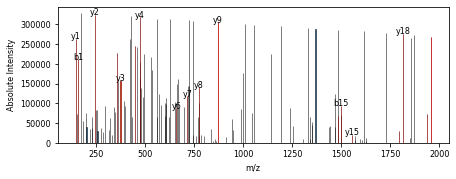

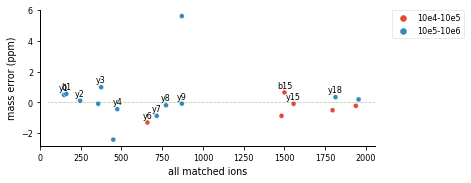

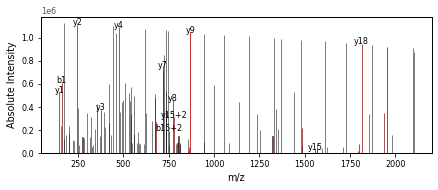

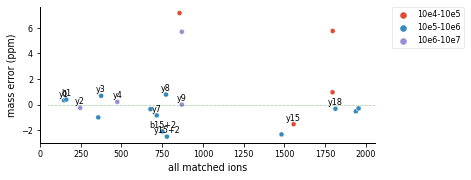

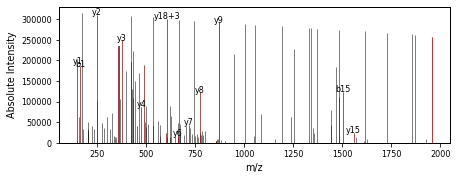

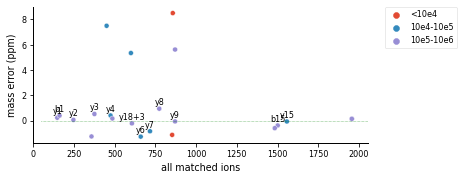

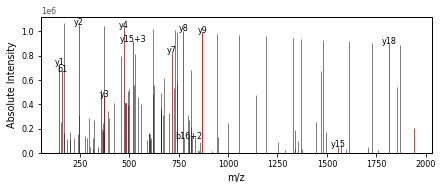

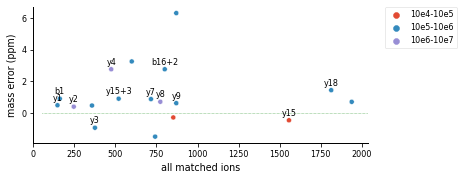

In [31]:
newDir = out_fol+"/ManualValidation_dta_ms2_Deiostope_test"
mkdir(newDir)
workbookName = newDir+"/Report_of_manual_validation.xlsx"
writer = pd.ExcelWriter(workbookName, engine='xlsxwriter')

N=34
updater=0

for specs in list(inputFileDf['combined']):
#   print (specs)
  xcorr= "missing"
  prob = "missing"
  lscoreSite = "missing"
  spectrumSplit = specs.split("\t")
  filename = newDir+"/"+"__".join(spectrumSplit)
  if "XCorr" in inputFileDf.columns:
    xcorr = inputFileDf.loc[inputFileDf['combined'] == specs].XCorr.values[0]
  if "SequenceProbablity" in inputFileDf.columns:
    prob = inputFileDf.loc[inputFileDf['combined'] == specs].SequenceProbablity.values[0]
  if "JUMPl_score" in inputFileDf.columns:
    lscoreSite = inputFileDf.loc[inputFileDf['combined'] == specs].JUMPl_score.values[0]
  spectrum_DF = newDF.loc[newDF.spectrum_peptide_mod == specs] 
#   print (spectrum_DF)
  peptide = spectrum_DF.loc[spectrum_DF.spectrum_peptide_mod == specs].plain_peptide.values[0]
  modsOri = spectrum_DF.loc[spectrum_DF.spectrum_peptide_mod == specs].mod_site.values[0]
  maxCharge = int(spectrum_DF.loc[spectrum_DF.spectrum_peptide_mod == specs].charge.values[0])
  mods = modsForReport(modsOri, peptide)
#   modsVariantsAll, massPosList = statModDynModAllVariants(peptide, mods, dyn_AA)
  massPosDict1 = spectrumToDict(spectrumSplit[-1])

#   print (massPosDict1)

  ion_types = ["b","y"]
  ionLoss = ["H2O","NH3","H3PO4"]
  
  df_pep = ionSeriesIonLossSpeRes(peptide,maxcharge=maxCharge,massPosDict=massPosDict1,useMod ="Yes")
  

  reqdCols = ["Seq"]
  for x in df_pep.columns:
    for y in ion_types:
      if y+"+" in x:
        reqdCols.append(x)
      for z in ionLoss:
        if y+"-"+z in x:
          reqdCols.append(x)
        
  df_pep2 = df_pep.copy()[reqdCols]   
  df_pep2["b-series"] = [*range(1, len(df_pep2)+1, 1)] 
  df_pep2["y-series"] = [*range(len(df_pep2),0, -1)]
  
  exp_mz_list = spectrum_DF.exp_mz_list.values[0]
  exp_int_list = spectrum_DF.intensity_list.values[0]
  
  match_list, match_int_list, true_ions_ppm_list=ionMatches(exp_mz_list, exp_int_list, df_pep, ion_types =ion_types, ionLoss=ionLoss, tol=10)
  
  
  
  
    
  df_pep2["Peptide_Mod_Seq"] = df_pep2.apply(displaySeqTable, massPosDict=massPosDict1, axis=1)

  displayTableCols = []
  for cols in df_pep2.columns:
    if "b" in cols:
      if "series" not in cols:
        displayTableCols.append(cols)
  displayTableCols=displayTableCols[::-1]
  displayTableCols.append("b-series")
  displayTableCols.append("Peptide_Mod_Seq")
  displayTableCols.append("y-series")
  for cols in df_pep2.columns:
    if "y" in cols:
      if "series" not in cols:
        displayTableCols.append(cols)

  df=df_pep2.copy()[displayTableCols]

  seriesName = []
  
  for vals in match_list:
    val = float(vals)
    row_column_pair = df_pep2[df_pep2.isin([val])].stack().index[0]
#     print (row_column_pair)
    row = row_column_pair[0]
    column = row_column_pair[1]
  #   print (row, column) 
    if "-" in column:
      columnSplit = column.split("-")
      if ("x" in column) or ("y" in column) or ("z" in column):
        ionNu = columnSplit[0]+str(df_pep2["y-series"][row])+"-"+columnSplit[1]
      if ("a" in column) or ("b" in column) or ("c" in column):
        ionNu = columnSplit[0]+str(df_pep2["b-series"][row])+"-"+columnSplit[1]
    else:
      columnSplit = column.split("+")
      if ("x" in column) or ("y" in column) or ("z" in column):
        ionNu = columnSplit[0]+str(df_pep2["y-series"][row])+"+"+columnSplit[1]
      if ("a" in column) or ("b" in column) or ("c" in column):
        ionNu = columnSplit[0]+str(df_pep2["b-series"][row])+"+"+columnSplit[1]
    seriesName.append(ionNu)
  seriesName = list(map(lambda x: x.replace('+1',''),seriesName))
#   print (len(list(spectrum_DF.matched_ions_list)[0]))
  plt.rcParams.update({'font.size': 8,'figure.max_open_warning': 0})
  plt.figure(figsize=(7,2.5))
  #plt.title(" ".join(specs.split("\t")))
  plt.xlabel('m/z')
  plt.ylabel('Intensity, absolute. units')
  plt.bar(list(spectrum_DF.exp_mz_list)[0], list(spectrum_DF.intensity_list)[0], width=0.1, linewidth=0.5,
        edgecolor='black')

  plt.bar(match_list, match_int_list, width=0.1, linewidth=0.5,
        edgecolor='red', alpha=0.7)

  plt.xlabel("m/z", color='black')

  plt.ylabel('Absolute Intensity', color='black')
  plt.tick_params(color='black')
  plt.xticks(color="black")
  plt.yticks(color="black")

  for i, txt in enumerate(seriesName):
    for label in ["b","y"]:
      if label in txt:
        if "-" not in txt:
          plt.annotate(txt, (match_list[i],match_int_list[i]), ha="center")


  
  #figurename = filename+"__intensityPlot.pdf"
  figurename1 = filename+"__intensityPlot.png"
  #plt.savefig(figurename, bbox_inches="tight", dpi=600 )
  plt.savefig(figurename1, bbox_inches="tight", dpi=600 )


  ionDFmatch = pd.DataFrame(columns=["matched_ions","matched_intensity","matched_ppm"])
  
  
  ionDFmatch["matched_ions"] = match_list
  ionDFmatch["matched_intensity"] = match_int_list
  ionDFmatch["matched_ppm"] = true_ions_ppm_list 
  bins = [0,10000,100000,1000000, 10000000,100000000,1000000000,10000000000]
  ionDFmatch['intRange'] = pd.cut(ionDFmatch.matched_intensity, bins=bins, include_lowest=True)
  ionDFmatch['right'] = ionDFmatch['intRange'].map(attrgetter('right'))
  ionDFmatch["intensity"] = ionDFmatch.apply(rightInterval,axis=1)


  fig, ax = plt.subplots(figsize=(6,2.5))
  plt.style.use("ggplot")


  plt.rcParams['axes.edgecolor'] = "#010101"
  plt.rcParams['axes.facecolor'] = '#FFFFFF'


  plt.rcParams.update({'font.size': 8,'figure.max_open_warning': 0})
  ax = plt.axes(facecolor="w")

  ionDFmatch2 =ionDFmatch.sort_values(by="right", ascending=True)
  sns.scatterplot(data=ionDFmatch2, x="matched_ions", y="matched_ppm",s=25,hue="intensity")
  
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.hlines(0, 50, 2200, color = "green", linestyles="dotted",linewidth=0.5)
  ax.set_ylabel("mass error (ppm)", color="black")
  ax.set_xlabel("all matched ions", color="black")
  ax.set_xlim(0,max(match_list)+100)
  ax.tick_params(axis='x', colors='black')
  ax.tick_params(axis='y', colors='black')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  for i, txt in enumerate(seriesName):
    for label in ["b","y"]:
      if label in txt:
        if "-" not in txt:
          plt.annotate(txt, (list(ionDFmatch.matched_ions)[i],list(ionDFmatch.matched_ppm)[i]+0.3), ha="center")

          name = "_".join(specs.split("\t"))
  
  #figurename = filename+"__ToleranceMap.pdf"
  figurename2 = filename+"__ToleranceMap.png"
    
  #plt.savefig(figurename, bbox_inches="tight", dpi=600 )
  plt.savefig(figurename2, bbox_inches="tight", dpi=600 )
  
  matched = str(len(ionDFmatch))+"/"+str(len(list(spectrum_DF.exp_mz_list)[0]))

  figurename3 = filename+"__MasterSeries.png"
  

  finalDF, seqSymbol = reformat_dataframe2(df, massPosDict1, match_list)
  finalDF2 = finalDF.style.applymap(lambda x: 'color: red' if x in match_list else 'color: black')

  massSeriesLength = df.shape[0]
  

  writer,updater, N = excelWriter2(writer, finalDF2, "Sheet1", figurename1, figurename2, spectrumSplit,xcorr, prob,lscoreSite, massSeriesLength,matched, seqSymbol,peptide, N, updater)
writer.save()

In [142]:
ionDFmatch

,matched_ions,matched_intensity,matched_ppm,intRange,right,intensity
0,147.112804,128584.828125,0.131340,"(100000.0, 1000000.0]",1000000.0,10e5-10e6
1,161.037925,124135.671875,0.524051,"(100000.0, 1000000.0]",1000000.0,10e5-10e6
2,229.154669,5937.312988,-1.091102,"(-0.001, 10000.0]",10000.0,<10e4
3,246.181218,235615.015625,0.042896,"(100000.0, 1000000.0]",1000000.0,10e5-10e6
4,357.213246,23065.699219,0.114418,"(10000.0, 100000.0]",100000.0,10e4-10e5
5,375.223811,20591.816406,-1.288641,"(10000.0, 100000.0]",100000.0,10e4-10e5
6,435.737617,144250.156250,0.263698,"(100000.0, 1000000.0]",1000000.0,10e5-10e6
7,474.292225,35088.886719,2.404425,"(10000.0, 100000.0]",100000.0,10e4-10e5
8,519.614584,11746.894531,0.546620,"(10000.0, 100000.0]",100000.0,10e4-10e5
9,599.323581,11613.911133,2.896517,"(10000.0, 100000.0]",100000.0,10e4-10e5


In [143]:
seriesName

['y1',
 'b1',
 'y2-NH3',
 'y2',
 'y3-H2O',
 'y3',
 'y9+2',
 'y4',
 'y15+3',
 'y18-H3PO4+3',
 'y6',
 'y7',
 'b15-H3PO4+2',
 'y14-NH3+2',
 'y8',
 'y15+2',
 'y9-H2O',
 'y9',
 'y18+2']

In [144]:
match_list

[147.11280416447,
 161.03792525148,
 229.15466897644998,
 246.18121807746,
 357.21324648173,
 375.22381116543,
 435.737617030515,
 474.29222507842,
 519.6145841325134,
 599.3235814316868,
 659.3722663042699,
 716.39373002484,
 741.854584000675,
 741.8942315545951,
 773.41519374541,
 778.9182379653851,
 852.4573929105601,
 870.46795759426,
 947.4701815163701]

In [57]:
testID_mzXML

,expScan,scan,m/z,intensity
11847,q190622_VL1377_D.11848,11848,"[157.06107, 175.11905, 176.95076, 181.0611, 18...","[913.10376, 2007.8042, 860.55383, 1329.0784, 9..."
10436,q190622_VL1377_B.10437,10437,"[171.1126, 173.05565, 181.06056, 183.11276, 18...","[1110.4092, 947.4857, 2042.3802, 3274.2834, 14..."
10551,q190622_VL1377_C.10552,10552,"[158.0925, 175.11899, 181.06076, 181.88376, 18...","[960.679, 1327.7266, 2118.575, 830.128, 1515.0..."
11934,q190622_VL1377_A.11935,11935,"[175.11874, 177.97424, 180.13132, 181.06053, 1...","[894.37494, 889.7175, 762.3605, 2328.2788, 952..."


In [62]:
x1 = pyteomics.mzxml.read(mzXML_list[1])  #reading mzXML file using pyteomics
df = pd.DataFrame([x for x in x1])  #dataframe of the mzXML file
ms2 = df.copy().loc[df.msLevel==2]     #ms2 level scans
run = mzXML_list[0].split("/")[-1].split(".mzXML")[0]
ms2["expScan"] = run+"."+ms2.num.astype("str")

ms2.rename(columns={"num":"scan","m/z array":"m/z","intensity array":"intensity"}, inplace=True)


In [77]:
intensity = list(ms2.loc[ms2.scan == "9630"]["intensity"])[0]
print ("m/z\tintensity")
for index, mz in enumerate(list(ms2.loc[ms2.scan == "9630"]["m/z"])[0].tolist()):
    print (mz,"\t",intensity[index])

m/z	intensity
143.11793518066406 	 1818.3582
144.0113525390625 	 2791.6692
145.06072998046875 	 5757.1885
147.11279296875 	 45465.758
153.13848876953125 	 1916.9196
154.58413696289062 	 1355.0579
155.04490661621094 	 2527.3782
155.0813446044922 	 2399.916
155.1178741455078 	 12422.948
161.0379180908203 	 34961.53
162.04150390625 	 1512.8063
164.48207092285156 	 1731.5536
169.09701538085938 	 4818.022
172.071533203125 	 4286.3325
173.12843322753906 	 54388.688
174.13197326660156 	 2232.8584
175.11868286132812 	 3496.3303
181.13340759277344 	 1593.1007
183.1126708984375 	 3194.5215
183.1494903564453 	 1596.2592
185.03793334960938 	 2023.2281
185.1647491455078 	 1900.1062
186.12376403808594 	 9517.887
186.12796020507812 	 1318.063
186.1343536376953 	 1887.36
194.8087615966797 	 1701.5466
200.1395263671875 	 2335.726
201.1234588623047 	 13154.9795
202.064453125 	 6698.592
203.0484161376953 	 5632.517
206.11953735351562 	 1512.2893
209.1285400390625 	 4932.2764
212.13934326171875 	 3904.501

In [47]:
mass.calculate_mass(formula="H+")

1.00727646677

In [48]:
int(612.323214)

612